In [1]:
import os
import h5py

import numpy as np
import scipy.stats as stats
import astropy.units as u
import astropy.cosmology as cosmo
from astropy.cosmology import FlatwCDM

In this notebook, we calculate the point-estimates in the $m_1 - m_2$ plane of the hypervolume $\langle VT \rangle$ for the *only O3b* LIGO observation run and reproduce the result in Table III in the GWTC-3 catalog paper. The mass combinations $(m_1, m_2)$ considered here are, in the unit of $M_\odot$, 
- $35.0 \pm 2.0 $ and $35.0 \pm 2.0 $
- $35.0 \pm 2.0 $ and $20.0 \pm 2.0 $
- $35.0 \pm 2.0 $ and $1.5 \pm 0.2 $
- $20.0 \pm 2.0 $ and $20.0 \pm 2.0 $
- $20.0 \pm 2.0 $ and $10.0 \pm 1.0 $
- $20.0 \pm 2.0 $ and $1.5 \pm 0.2 $
- $10.0 \pm 1.0 $ and $10.0 \pm 1.0 $
- $10.0 \pm 1.0 $ and $5.0 \pm 1.0 $
- $10.0 \pm 1.0 $ and $1.5 \pm 0.2 $
- $5.0 \pm 1.0 $ &nbsp; and $5.0 \pm 1.0 $
- $5.0 \pm 1.0 $ &nbsp; and $1.5 \pm 0.2 $
- $1.5 \pm 0.2 $ &nbsp; and $1.5 \pm 0.2 $

The hypervolume $\langle VT \rangle$ is defined as $\Lambda = R_0 \langle VT \rangle$, where $\Lambda$ is the expected number of detected events given a population model and $R_0$ is the merger rate at redshift $z=0$. 
We also assume the sources are uniformly distributed in comoving volume and source-frame time. Given $N_{draw}$ number of injections, the expected number of detected events is:

\begin{align}
\Lambda(\lambda) \equiv \frac{1}{N_{draw}} \sum_{i=1}^{N_{det}} 
\frac{1}{p_{draw}(\theta_i)} 
\frac{dN}{d{\theta_i}} (\lambda)
\end{align}

where $\lambda$ is the population parameters, $\theta_i$ is the injection parameters, $p_{draw}$ is the draw distribution of the injections, and $N_{det}$ is the number of injections found by our detection pipelines.
In our analysis, $N_{det}$ is the number of injection events with $p_{astro} > 0.5$.

We start by reading in the End O3 injection summary file in HDF5 format. The important attributes of the injection file are:

- `analysis_time_s`: the total analysis time $T_{obs}$
- `total_generated`: the total number of injections $N_{draw}$
- `injections/mass_1_source`: source-frame primary mass $m_1$
- `injections/mass_2_source`: source_frame secondary mass $m_2$
- `injections/redshift`: redshift $z$
- `injections/spin1x`, `injections/spin1y`, `injections/spin1z`: spin of primary mass
- `injections/spin2x`, `injections/spin2y`, `injections/spin2z`: spin of secondary mass
- `injections/sampling_pdf`: the draw distribution $p_{draw}(m_1, m_2, s_1, s_2, z)$
- `injections/pastro_$pipeline`: the $p_{astro}$ of each detection pipeline. The pipeline considered here are cWB, GstLAL, MBTA, PyCBC BBH, and PyCBC Broad

In [2]:
# Read in attributes from injection summary file
injection_file = "endo3_mixture-LIGO-T2100113-v12-1256655642-12905976.hdf5"
with h5py.File(injection_file, 'r') as f:
    T_obs = f.attrs['analysis_time_s']/(365.25*24*3600) # years
    N_draw = f.attrs['total_generated']

    m1 = f['injections/mass1_source'][:]
    m2 = f['injections/mass2_source'][:]
    s1x = f['injections/spin1x'][:]
    s1y = f['injections/spin1y'][:]
    s1z = f['injections/spin1z'][:]    
    s2x = f['injections/spin2x'][:]
    s2y = f['injections/spin2y'][:]
    s2z = f['injections/spin2z'][:]
    z = f['injections/redshift'][:]

    p_draw = f['injections/sampling_pdf'][:]

    pastro_cwb = f['injections/pastro_cwb'][:]
    pastro_gstlal = f['injections/pastro_gstlal'][:]    
    pastro_mbta = f['injections/pastro_mbta'][:]    
    pastro_pycbc_bbh = f['injections/pastro_pycbc_bbh'][:]    
    pastro_pycbc_broad = f['injections/pastro_pycbc_hyperbank'][:]

Let $\theta = \{m_1, m_2, s_1, s_2\}$ be the intrinsic injection source parameters. The expected number of detected events $\Lambda$ can be written as:

\begin{align}
\Lambda 
= \frac{1}{N_{draw}} \sum_{i=1}^{N_{det}}
\frac{1}{p_{draw}(\theta_i, z_i)}  \frac{dN}{d\theta dz} (\theta_i, z_i) 
= \frac{1}{N_{draw}} \sum_{i=1}^{N_{det}}
\frac{p(\theta_i)}{p_{draw}(\theta_i, z_i)}  \frac{dN}{dz} (z_i)
\end{align}

Here, we assume the intrinsic parameter distribution $p(\theta)$ is properly normalized, and the distributions over $\theta$ and $z$ are separable so that:

\begin{gather}
\frac{dN}{d\theta dz} = p(\theta) \frac{dN}{dz} \\
\Rightarrow \frac{dN}{dz} = \int \frac{dN}{dm_1 dm_2 ds_1 ds_2 dz} dm_1 dm_2 ds_1 ds_2
\end{gather}

The sources are uniformly distributed in comoving volume and source-frame time. In other words:

\begin{align}
\frac{dN}{dV_c dt_{source}} = R(z) = R_0
\Rightarrow 
\frac{dN}{dz} = \left[\frac{dV_c}{dz}\frac{T_{obs}}{1 + z}\right] R_0
\end{align}

Combining with the $\Lambda$ equation, the hypervolume $\langle VT \rangle$ can be written as:

\begin{gather}
\Lambda = R_0 \langle VT \rangle \\ 
\Rightarrow  \boxed{\; \langle  VT \rangle  = \frac{1}{N_{draw}} \sum_{i=1}^{N_{det}}
\frac{p(\theta_i)}{p_{draw}(\theta_i, z_i)}\frac{T_{obs}}{1 + z_i}\frac{dV_c}{dz}(z_i)  }
\end{gather}

The uncertainty can be found in [Farr 2019](https://iopscience.iop.org/article/10.3847/2515-5172/ab1d5f):

\begin{align}
\boxed{\sigma^2_{VT} \equiv \frac{\sigma^2_\mu}{R_0^2} = \frac{\langle VT \rangle^2}{N_{eff}} 
= \frac{1}{N_{draw}^2}\sum_{i=0}^{N_{det}}\left(\frac{1}{p_{draw}(\theta_i, z_i)}\frac{1}{R_0}\frac{dN}{d\theta dz}\right)^2 - \frac{\langle VT \rangle^2}{N_{draw}}}
\end{align}

We define our population distribution and cosmology as follow:

- Masses distribution: The masses distribution is chosen to be log-normal distribution with a standard deviation of $\sigma = 0.1$ (which is roughly equivalent to $\pm$ 10% in mass):
\begin{align}
p(m_1, m_2) = 
\begin{cases}
\frac{C}{2\pi \sigma^2 m_1 m_2} 
\exp{\left(-\frac{1}{2}\frac{(\log m_1 - \log M)^2}{\sigma^2}\right)} 
\exp{\left(-\frac{1}{2}\frac{(\log m_2 - \log m)^2}{\sigma^2}\right)} 
& \text{for } m_2 < m_1 \\
0 & \text{otherwise}
\end{cases}
\end{align}

- Spins distribution: The spins distribution for both BH and NS is chosen to be uniform in magnitude (up to a maximum value) and isotropic. In other words:
\begin{align}
p(s_x, s_y, s_z | m) = \frac{1}{|s|^2} p(|s|, \cos\theta, \phi | m) = \frac{1}{4 \pi s_{max} |s|^2}
\end{align}
where $|s|^2 = s_x^2 + s_y^2 + s_z^2$. The maximum spin $s_{max}$ is 0.998 for black holes ($m > 2 M_\odot$)and 0.4 for neutron stars ($ m < 2 M_\odot$).

- Cosmology: We use the same cosmology with LIGO analysis:
    - $\Omega_m = 0.3065$
    - $\Omega_{\Lambda} = 0.6935$
    - $\Omega_{\gamma} = 0.0$
    - $H_0 = 67.9$ km / (Mpc s)
    - $\omega_0 = -1$

In [3]:
def logprob_mass2_lognorm(m2, m1, params):
    ''' evaluate p(m2 | m1) = c * lognormal(m2 | m, sigma) 
    where 
    - lognormal is log-normal distribution that is truncated at m1
    - c is the normalization correction factor    
    '''
    m2_mean = params['m2_mean']
    sig_lognorm = params['sig_lognorm']
    
    logc = -stats.lognorm.logcdf(m1, sig_lognorm, scale=m2_mean)
    return np.where(
        m2 <  m1, stats.lognorm.logpdf(m2, sig_lognorm, scale=m2_mean) + logc, np.NINF)

def logprob_mass_lognorm(m1, m2, params):
    ''' evaluate p(m1, m2) = p(m1) p(m2 | m1)
    with 
    - p(m1) = log_normal(m1; m, 0.1)
    - p(m2 | m1) = log_normal(m2; m, 0.1) truncated such that m2 < m1    
    '''
    
    sig_lognorm = params['sig_lognorm']
    m1_mean = params['m1_mean']
    
    log_pm1 = stats.lognorm.logpdf(m1, sig_lognorm, scale=m1_mean)
    log_pm2 = logprob_mass2_lognorm(m2, m1, params)

    return log_pm1 + log_pm2

def logprob_spin(sx, sy, sz, params):
    ''' Evaluate p(sx, sy, sz) = (1. / |s|^2) p(|s|, cos theta, phi) = 1. / (4 pi s_max |s|^2)
    where:
    - |s| = sqrt(sx^2 + sy^2 + sz^2)
    
    The mass `m` determines which s_max to use
    '''
    smax = params['smax']    
    s2 = sx**2 + sy**2 + sz**2 
    return np.where(s2 < smax**2, - np.log(4 * np.pi) - np.log(smax) - np.log(s2), np.NINF)

We will be calculate $\langle VT \rangle$ for 12 different masses combinations, so we'd like to define some convienence function.

In [4]:
def log_dNdm1dm2ds1ds2dz(
    m1, m2, s1x, s1y, s1z, s2x, s2y, s2z, z, 
    logprob_mass, logprob_spin, selection, params):
    ''' Calculate dN / dm1 dm2 ds1 ds2 dz for selected injections 
    
    Arguments:
    - m1, m2: primary and secondary spin components
    - s1x, s1y, s1z: primary spin components
    - s2x, s2y, s2z: secondary spin components
    - z: redshift
    - logprob_mass: function that takes in m1, m2 and calculate log p(m1, m2) 
    - logprob_spin: function that takes in spin parameters and calculate log p(s)
    - selection: selection function
    - params: parameters for distribution func
    '''
    
    log_pm = logprob_mass(m1, m2, params)  # mass distribution p(m1, m2)
    
    # primary spin distribution
    s1_max = np.where(m1 < 2, params['smax_ns'], params['smax_bh'])
    spin1_params = params.copy()
    spin1_params['smax'] = s1_max
    log_ps1 = logprob_spin(s1x, s1y, s1z, spin1_params)
    
    # secondary spin distribution
    s2_max = np.where(m2 < 2, params['smax_ns'], params['smax_bh'])
    spin2_params = params.copy()
    spin2_params['smax'] = s2_max
    log_ps2 = logprob_spin(s2x, s2y, s2z, spin2_params)
    
    # total spin distribution
    log_ps = log_ps1 + log_ps2
      
    # Calculate the redshift terms, ignoring rate R0 because it will cancel out anyway
    # dN / dz = dV / dz  * 1 / (1 + z) + (1 + z)^kappa
    # where the second term is for time dilation
    # ignoring the rate because it will cancel out anyway
    cosmo = params['cosmo']
    log_dNdV = 0
    log_dVdz = np.log(4 * np.pi) + np.log(cosmo.differential_comoving_volume(z).to(
        u.Gpc**3 / u.sr).value)
    log_time_dilation = - np.log(1 + z)
    log_dNdz = log_dNdV + log_dVdz + log_time_dilation
    
    return np.where(selection, log_pm + log_ps + log_dNdz, np.NINF)

def logdiffexp(x, y):
    ''' Evaluate log(exp(x) - exp(y)) '''
    return x + np.log1p( - np.exp(y - x) )


def get_logVT(m1, m2, s1x, s1y, s1z, s2x, s2y, s2z, z, 
          logprob_mass, logprob_spin, selection, T_obs, N_draw, p_draw, params):
    ''' Convienient function that returns log_VT, log_sigma_VT, and N_eff '''
    
    # Calculate VT
    log_dN = log_dNdm1dm2ds1ds2dz(
        m1, m2, s1x, s1y, s1z, s2x, s2y, s2z, z, 
        logprob_mass, logprob_spin, selection, params)
    log_VT = np.log(T_obs) - np.log(N_draw) + np.logaddexp.reduce(log_dN - np.log(p_draw))

    # Calculate uncertainty of VT and effective number 
    log_s2 = 2 * np.log(T_obs) - 2 * np.log(N_draw) + np.logaddexp.reduce(
        2 * (log_dN - np.log(p_draw)))
    log_sig2 = logdiffexp(log_s2, 2.0*log_VT - np.log(N_draw))
    log_sig = log_sig2 / 2
    N_eff = np.exp(2 * log_VT - log_sig2)
    
    return log_VT, log_sig, N_eff

In this example, an event passes a detection selection cut if the $p_{astro}$ of *any* detection pipeline is greater than 0.5. We calculate the hypervolume $\langle VT \rangle$ given this selection criterion below:

In [5]:
# Define masses combinations
M1 = np.array([35, 35, 35, 20, 20, 20, 10, 10, 10, 5, 5, 1.5])
M2 = np.array([35, 20, 1.5, 20, 10, 1.5, 10, 5, 1.5, 5, 1.5, 1.5])

# Define parameters of population distribution and cosmology
sig_lognorm = 0.1
smax_ns = 0.4
smax_bh = 0.998
cosmo = FlatwCDM(H0=67.9, Om0=0.3065, w0=-1)

# Define the selection function
selection = (
    (pastro_cwb > 0.5) | (pastro_gstlal > 0.5) | (pastro_mbta > 0.5) |
    (pastro_pycbc_bbh > 0.5) | (pastro_pycbc_broad > 0.5)
)

# Loop over and calculate VT for all masses combinations
VT, sigma_VT = [], []  # vt and its error 

for i, (m1_mean, m2_mean) in enumerate(zip(M1, M2)):
    pop_params = {
        'm1_mean': m1_mean,
        'm2_mean': m2_mean,
        'sig_lognorm': sig_lognorm,
        'smax_ns': smax_ns,
        'smax_bh': smax_bh,
        'cosmo': cosmo
    }

    # Calculate VT, sigma_VT and N_eff
    log_vt, log_sigma_vt, N_eff = get_logVT(
        m1, m2, s1x, s1y, s1z, s2x, s2y, s2z, z, 
        logprob_mass_lognorm, logprob_spin, selection, T_obs, N_draw, p_draw, pop_params)
    vt = np.exp(log_vt)
    sigma_vt = np.exp(log_sigma_vt)
    
    # Print out VT, its error and Neff for each masses combination
    print('Mass (m1, m2) = ({:4.1f}, {:4.1f}): VT = {:6.2g} +- {:8.2g} | N_eff = {:.2f}'.format(
        m1_mean, m2_mean, vt, sigma_vt, N_eff))

    # Add to array 
    VT.append(vt)
    sigma_VT.append(sigma_vt)

Mass (m1, m2) = (35.0, 35.0): VT =    5.3 +-    0.092 | N_eff = 3279.26
Mass (m1, m2) = (35.0, 20.0): VT =    3.1 +-    0.085 | N_eff = 1293.52
Mass (m1, m2) = (35.0,  1.5): VT =  0.033 +-   0.0021 | N_eff = 243.05
Mass (m1, m2) = (20.0, 20.0): VT =    1.7 +-    0.038 | N_eff = 2035.27
Mass (m1, m2) = (20.0, 10.0): VT =   0.77 +-    0.035 | N_eff = 488.38
Mass (m1, m2) = (20.0,  1.5): VT =  0.029 +-   0.0014 | N_eff = 455.99
Mass (m1, m2) = (10.0, 10.0): VT =   0.32 +-    0.011 | N_eff = 940.47
Mass (m1, m2) = (10.0,  5.0): VT =   0.13 +-   0.0088 | N_eff = 224.54
Mass (m1, m2) = (10.0,  1.5): VT =  0.021 +-  0.00072 | N_eff = 825.90
Mass (m1, m2) = ( 5.0,  5.0): VT =  0.074 +-   0.0031 | N_eff = 577.37
Mass (m1, m2) = ( 5.0,  1.5): VT =  0.014 +-  0.00037 | N_eff = 1464.07
Mass (m1, m2) = ( 1.5,  1.5): VT = 0.0039 +-  8.7e-05 | N_eff = 1973.66


We note that Table III in GWTC-3 reports 90% credible intervals. Our example reports 68% credible intervals (1-sigma). However, the conversion is trivial. 

For better visualization, we also plot VT on the $(m_1, m_2)$ plane.

In [6]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors

%matplotlib inline
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'STIXGeneral'
mpl.rcParams['font.size'] = 15
mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'

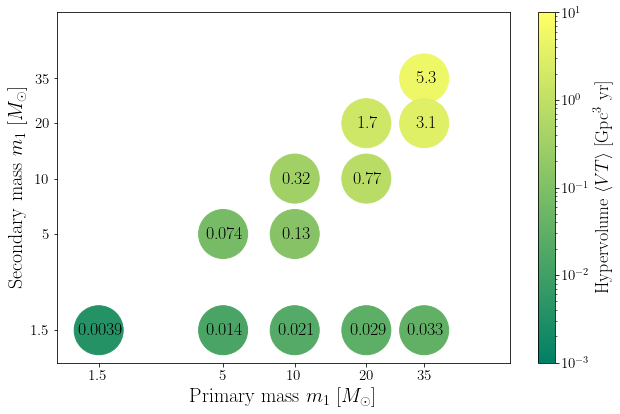

In [7]:
fig, ax = plt.subplots(1, figsize=(9, 6))

# plot VT scatter plot with different masses combinations
color_norm = colors.LogNorm(vmin=1e-3, vmax=10)
sc = ax.scatter(
    M1, M2, c=VT, s=2400, cmap='summer', norm=color_norm,
    label='Any')

# annote scatter plot
for i in range(len(VT)):
    vt = VT[i]
    text = '{:.2g}'.format(vt)

    # handtuning the loc of annotated text
    # to make the text more centered
    if len(text) == 3:
        x, y = (M1[i] * 0.92, M2[i] * 0.94)
    elif len(text) == 4:
        x, y = (M1[i] * 0.88, M2[i] * 0.94)
    elif len(text) == 5:
        x, y = (M1[i] * 0.85, M2[i] * 0.94)
    elif len(text) == 6:
        x, y = (M1[i] * 0.82, M2[i] * 0.94)
    else:
        x, y = (M1[i] * 0.90, M2[i] * 0.94)
    ax.text(x, y, text, fontsize=18)

# axes label
ax.set_xlabel(r'Primary mass $m_1$ [$M_{\odot}$]', fontsize=20)
ax.set_ylabel(r'Secondary mass $m_1$ [$M_{\odot}$]', fontsize=20)

# axes scale and limit
ax.set_xlim(1, 80)
ax.set_ylim(1, 80)
ax.loglog(base=2)

# axes tick labels
ticklabels = (1.5, 5, 10, 20, 35)
ax.set_xticks(ticklabels)
ax.set_xticklabels(ticklabels)
ax.set_yticks(ticklabels)
ax.set_yticklabels(ticklabels)

# format colorbar
cbar = fig.colorbar(sc)
cbar.set_label(r'Hypervolume $\langle VT \rangle$ [Gpc$^3$ yr]',
             fontsize=18)

fig.tight_layout()